In [1]:
# Importing necessary packages
import os                                                 # set current working directory 
import sys                                                # enable/disable some outputs for clarity
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import geostatspy.geostats as geostats                    # synthetic data generation using Sequential Gaussian Simulation
import geostatspy.GSLIB as GSLIB                          # synthetic data generation using Sequential Gaussian Simulation
import math                                               # n_effective calculations
import scipy                                              # n_effective calculations
import json                                               # saving results to json files for easier handling

from sklearn.model_selection import train_test_split      # split dataset into train test
from IPython.display import clear_output

%matplotlib inline
cmap = plt.cm.inferno # color map

In [2]:
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

def vargplot(feature,lags,gamma_maj,gamma_min,npps_maj,npps_min,vmodel,azi,atol,sill):     # plot the variogram
    index_maj,lags_maj,gmod_maj,cov_maj,ro_maj = geostats.vmodel(nlag=100,xlag=10,azm=azi,vario=vmodel);
    index_min,lags_min,gmod_min,cov_min,ro_min = geostats.vmodel(nlag=100,xlag=10,azm=azi+90.0,vario=vmodel);
    
    plt.scatter(lags,gamma_maj,color = 'black',s = npps_maj*0.005,label = 'Major Azimuth ' +str(azi), alpha = 0.8)
    #plt.plot(lags_maj,gmod_maj,color = 'black')
    plt.scatter(lags,gamma_min,color = 'red',s = npps_min*0.005,label = 'Minor Azimuth ' +str(azi+90.0), alpha = 0.8)
    #plt.plot(lags_min,gmod_min,color = 'red')
    plt.plot([0,2000],[sill,sill],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    if atol < 90.0:
        plt.title('Directional ' + feature + ' Variogram')
    else: 
        plt.title('Omni Directional NSCORE ' + feature + ' Variogram')
    plt.xlim([0,1000]); #plt.ylim([0,1.8])
    plt.legend(loc="lower right")
    plt.grid(b=True, which='major', color='black', linestyle='-')
    plt.grid(b=True, which='minor', color='gray', linestyle='--')
    plt.minorticks_on()
    
from numba import jit # for numerical speed up

@jit(nopython=True)
def cova2(x1, y1, x2, y2, nst, c0, pmx, cc, aa, it, ang, anis, rotmat, maxcov):
    """Calculate the covariance associated with a variogram model specified by a
    nugget effect and nested variogram structures.
    :param x1: x coordinate of first point
    :param y1: y coordinate of first point
    :param x2: x coordinate of second point
    :param y2: y coordinate of second point
    :param nst: number of nested structures (maximum of 4)
    :param c0: isotropic nugget constant (TODO: not used)
    :param pmx: TODO
    :param cc: multiplicative factor of each nested structure
    :param aa: parameter `a` of each nested structure
    :param it: TODO
    :param ang: TODO: not used
    :param anis: TODO
    :param rotmat: rotation matrices
    :param maxcov: TODO
    :return: TODO
    """
    EPSLON = 0.000001

    # Check for very small distance
    dx = x2 - x1
    dy = y2 - y1

    if (dx * dx + dy * dy) < EPSLON:
        cova2_ = maxcov
        return cova2_

    # Non-zero distance, loop over all the structures
    cova2_ = 0.0
    for js in range(0, nst):
        # Compute the appropriate structural distance
        dx1 = dx * rotmat[0, js] + dy * rotmat[1, js]
        dy1 = (dx * rotmat[2, js] + dy * rotmat[3, js]) / anis[js]
        h = math.sqrt(max((dx1 * dx1 + dy1 * dy1), 0.0))
        if it[js] == 1:
            # Spherical model
            hr = h / aa[js]
            if hr < 1.0:
                cova2_ = cova2_ + cc[js] * (1.0 - hr * (1.5 - 0.5 * hr * hr))
        elif it[js] == 2:
            # Exponential model
            cova2_ = cova2_ + cc[js] * np.exp(-3.0 * h / aa[js])
        elif it[js] == 3:
            # Gaussian model
            hh = -3.0 * (h * h) / (aa[js] * aa[js])
            cova2_ = cova2_ + cc[js] * np.exp(hh)
        elif it[js] == 4:
            # Power model
            cov1 = pmx - cc[js] * (h ** aa[js])
            cova2_ = cova2_ + cov1
    return cova2_

@jit(nopython=True)
def setup_rotmat(c0, nst, it, cc, ang, pmx):
    """Setup rotation matrix.
    :param c0: nugget constant (isotropic)
    :param nst: number of nested structures (max. 4)
    :param it: TODO
    :param cc: multiplicative factor of each nested structure
    :param ang: TODO
    :param pmx: TODO
    :return: TODO
    """
    PI = 3.141_592_65
    DTOR = PI / 180.0

    # The first time around, re-initialize the cosine matrix for the variogram
    # structures
    rotmat = np.zeros((4, nst))
    maxcov = c0
    for js in range(0, nst):
        azmuth = (90.0 - ang[js]) * DTOR
        rotmat[0, js] = math.cos(azmuth)
        rotmat[1, js] = math.sin(azmuth)
        rotmat[2, js] = -1 * math.sin(azmuth)
        rotmat[3, js] = math.cos(azmuth)
        if it[js] == 4:
            maxcov = maxcov + pmx
        else:
            maxcov = maxcov + cc[js]
    return rotmat, maxcov

def n_effective(df,xcol,ycol,seed,nreal,vario):
    """Calculate the number of effective data from spatial locations and spatial continuity model
    Used in bootstrap to account for spatial continuity, use n effective instead of number of data
    :param df: source DataFrame
    :param xcol: column with the X locations
    :param ycol: column with the Y locations
    :param seed: random number seed for the random sampling
    :param nreal: number of realizations to sample the variance of the average 
    :param vario: variogram model as a dictionary, see the GeostatsPy Package's GSLIB.make_variogram() function 
    :return: n_eff as effective number of data
    """ 

# Set constants
    np.random.seed(seed)
    PMX = 9999.9
    
# load the variogram
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:                                   # include 2nd structure if present (optional)
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];
    
# Set up the rotation matrix
    rotmat, maxcov = setup_rotmat(c0,nst,it,cc,ang,PMX)
    
# Load the data
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    
# Calculate Symmetric Covariance Array - assuming variogram with spherical structure with range specified
    cov = np.zeros((nd,nd))
    for i in range(0, nd):
        x1 = x[i]; y1 = y[i]
        for j in range(0, nd):
            x2 = x[j]; y2 = y[j]
            cova = cova2(x1, y1, x2, y2, nst, c0, PMX, cc, aa, it, ang, anis, rotmat, maxcov)
            cov[i,j] = cova
            
# Lower and upper deconvolution            
    P, L, U = scipy.linalg.lu(cov) 
    
# Build realization and calculate the average    
    average_array = np.zeros(nreal)
    rand = np.zeros((nd)) 
    for l in range(0, nreal):
        rand = np.random.normal(loc = 0.0, scale = 1.0, size = nd)
        realization = np.matmul(L,rand)
        average_array[l] = np.average(realization)
        
# Back out the number of effecitve data useing the standard error in the average
    var_average = np.var(average_array)
    n_eff = max(min(1.0/var_average, nd),1.0)    # filter n effective less than 1.0 or greater than number of data
    
    return n_eff

def bootstrap(vals, L, size=None):
    if(size):
        return np.random.choice(vals, size=(int(size), L), replace=True)
    else:
        return np.random.choice(vals, size=(vals.shape[0], L), replace=True)

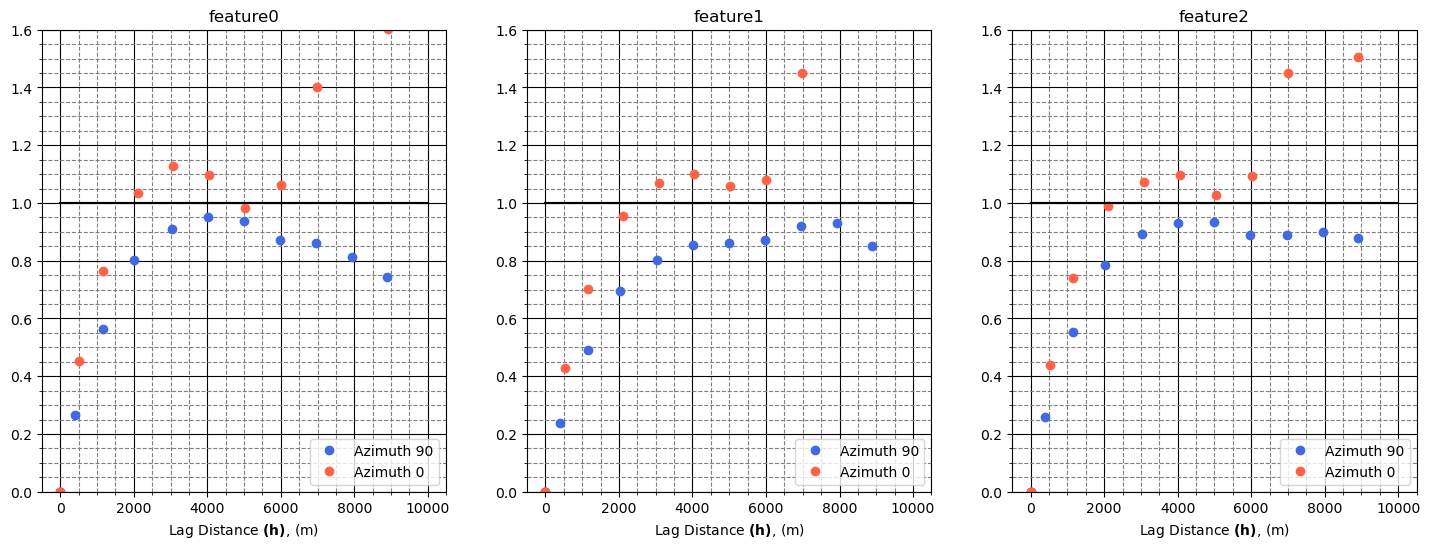

4200_1900_10


hmaj:  


In [ ]:
##### Directional Variogram Plotting
# Setting variogram parameters
tmin = -9999.; tmax = 9999.                            # no trimming 
lag_dist = 1000; lag_tol = 700; nlag = 10;            
bandh = 9999.9; atol = 22.5                            # no bandwidth, directional variograms
isill = 1                                              # standardize sill

# Setting a 'guess' major angle of 90. This guess could be changed
# to a list for an application where major is not known, so that each
# major guess is plotted. May need additional tweaking.
major_guess = 90
minor_guess = major_guess - 90
azi_mat = [major_guess, minor_guess]

with open('.workflow_ignore.txt') as f:
    ignore_list = f.read().splitlines()

filename_list = [f.path.split('/')[-1] for f in os.scandir('dataset/') if(f.is_dir() and f.path.split('/')[-1] not in ignore_list)] # Getting files

for filename in filename_list:
    df = pd.read_csv('dataset/' + filename + '/' + filename + '.csv')
    df = df[(df.x%2==0) & (df.y%2==0)]
    
    # We are sampling in every 500 meter for a realistic scenario
    # The data where every 100x100 isotropic cell is stored is going
    # to be our truth model for the results.
    df = df.iloc[::5] 

    predictors = df.iloc[:,2:-1].columns.values
    response = df.columns[-1]
    predictors_and_response = df.iloc[:,2:].columns.values

    num_predictors = predictors.shape[0] # NO NEED, but defined just in case
    num_response = 1 # NO NEED, but defined just in case
    num_predictors_and_response = predictors_and_response.shape[0] # Used for loops

    df_train, df_test = train_test_split(df, test_size=0.5, random_state=73073)
    X_train = df_train.loc[:, predictors].values
    y_train = df_train.loc[:, response].values
    X_test = df_test.loc[:, predictors].values
    y_test = df_test.loc[:, response].values
    
    plt.figure(figsize=(24,6))
    for i in range(1, num_predictors_and_response+1):
        plt.subplot(1, num_predictors_and_response+1, i)
        for idx_azi in range(len(azi_mat)):
            lag, gamma, npp = geostats.gamv(df_train,'x','y',predictors_and_response[i-1],tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[idx_azi],atol,bandh,isill)
            if(azi_mat[idx_azi]==major_guess):
                plt.plot(lag, gamma,'o',label = 'Azimuth ' +str(azi_mat[idx_azi]), color='royalblue')
            elif(azi_mat[idx_azi]==minor_guess):
                plt.plot(lag, gamma,'o',label = 'Azimuth ' +str(azi_mat[idx_azi]), color='tomato')
            else:
                plt.plot(lag, gamma,'x',label = 'Azimuth ' +str(azi_mat[idx_azi]))
            plt.plot([0,lag_dist * nlag],[1.0,1.0],color = 'black')
            plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
            if(i==0):
                plt.ylabel(r'$\gamma \bf(h)$')
            plt.ylim([0,1.6])
            plt.title(predictors_and_response[i-1])
            plt.legend(loc='lower right')
            plt.grid(visible=True, which='major', color='black', linestyle='-')
            plt.grid(visible=True, which='minor', color='gray', linestyle='--')
            plt.minorticks_on()

    plt.show()
    print(filename)
    while True:
        try:
            hmaj = int(input('hmaj: '))    
            hmin = int(input('hmin: '))
            nug = float(input('nug: ')) 
            # Calculating the n_effective
            nst = 1                                             
            it1 = 1; cc1 = 1; azi1 = major_guess; hmaj1 = hmaj; hmin1 = hmin

            vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1) # make model object
            n_eff_calculated = n_effective(df_train,'x','y',seed=73073,nreal=1000,vario=vario)
            n_eff_calculated = math.ceil(n_eff_calculated)
            n_standard = df_train.shape[0]
            break
        except ValueError:
            continue
    
    #### CLEAN SCREEN
    clear_output()
    
    # Obtain Variogram parameters and n_effective
    var_params_dict = dict(vario)  # Copying vario dictionary
    var_params_dict.update({'n_eff_calculated' : n_eff_calculated, 'n_standard': n_standard})
    json_string = json.dumps(var_params_dict)
    with open('dataset/' + filename + '/' + filename + '_var_params_and_n_eff.json', 'w') as f:
        f.write(json_string)